In [1]:
import sys
sys.path.append("../trainer")

In [2]:
import os

import torch
import torchvision as tv
from transformers import AutoTokenizer

/Users/israelcampiotti/Documents/Github/msc/tmp-master/plenv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
from datamodule import SROIETask2DataModule
from model import TransformersEncoder
from cnn import CNN as VisualModel
from ctc import GreedyDecoder

In [4]:
tokenizer = AutoTokenizer.from_pretrained("../trainer/tokenizer")

In [5]:
DATA_PATH = "../SROIETask2"
dm = SROIETask2DataModule(
    root_dir=os.path.join(DATA_PATH, "data"),
    label_file=os.path.join(DATA_PATH, "data.json"),
    tokenizer=tokenizer,
    height=32,
    num_workers=4,
    train_bs=2,
    valid_bs=2,
    max_width=None,
    do_pool=True,
)

In [6]:
dm.setup("fit")

In [7]:
batch = next(iter(dm.val_dataloader()))

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

In [8]:
images, labels, attention_mask, attention_image = batch

In [9]:
images.shape, labels.shape, attention_mask.shape, attention_image.shape

(torch.Size([2, 3, 32, 234]),
 torch.Size([2, 19]),
 torch.Size([2, 19]),
 torch.Size([2, 57]))

In [10]:
tokenizer.batch_decode(labels, skip_special_tokens=True)

['RESTORAN WAN SHENG', '002043319-W']

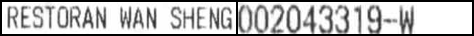

In [11]:
# create a grid using torchvision.utils.make_grid to display images
grid = tv.utils.make_grid(images, nrow=2)
# display images in grid
tv.transforms.ToPILImage()(grid)

# Tr model

In [12]:
from transformers import DebertaV2ForTokenClassification, DebertaV2Config


class TransformersEncoder(torch.nn.Module):
    def __init__(self, vocab_size: int = 100):
        super().__init__()

        config_dict = {
            "model_type": "deberta-v2",
            "architectures": ["DebertaV2ForTokenClassification"],
            "num_labels": vocab_size,
            "model_type": "deberta-v2",
            "attention_probs_dropout_prob": 0.25,
            "hidden_act": "gelu",
            "hidden_dropout_prob": 0.25,
            "hidden_size": 512,
            "initializer_range": 0.02,
            "intermediate_size": 768,  # 3072,
            "max_position_embeddings": 512,
            "relative_attention": True,
            "position_buckets": 256,
            "norm_rel_ebd": "layer_norm",
            "share_att_key": True,
            "pos_att_type": "p2c|c2p",
            "layer_norm_eps": 1e-7,
            "max_relative_positions": -1,
            "position_biased_input": False,
            "num_attention_heads": 8,
            "num_hidden_layers": 3,
            "type_vocab_size": 0,
            "pad_token_id": 1,
            "vocab_size": vocab_size,
        }
        config = DebertaV2Config(**config_dict)
        self.encoder = DebertaV2ForTokenClassification(config)

    def forward(self, image_embeddings, attention_mask=None):
        outputs = self.encoder(
            inputs_embeds=image_embeddings, attention_mask=attention_mask
        )
        return outputs.logits

rec_model = TransformersEncoder(vocab_size=tokenizer.vocab_size)

# Visual Model

In [13]:
from torch import nn

class Swish(nn.Module):
    def forward(self, x):
        return x * torch.sigmoid(x)


class Feature2Embedding(nn.Module):
    """
    Convert [B, C, H, W] image feature tensor to [B, seq_len, D] (B, 512, 512)
    (B, C, H, W) -> (B, W, H, C)
    """

    def forward(self, x):
        n, c, h, w = x.shape
        return x.permute(0, 3, 2, 1).reshape(n, -1, c)


class ImageFeatureExtractor(nn.Module):
    def __init__(self, imgH=32, nc=3, vocab_size=100):
        super(ImageFeatureExtractor, self).__init__()
        assert imgH % 16 == 0, "imgH has to be a multiple of 16"

        ks = [3, 3, 3, 3, 3, 3, 2]
        ps = [1, 1, 1, 1, 1, 1, 0]
        ss = [1, 1, 1, 1, 1, 1, 1]
        nm = [64, 128, 256, 256, 512, 512, 512]

        cnn = nn.Sequential()

        def convSwish(i, batchNormalization=False):
            nIn = nc if i == 0 else nm[i - 1]
            nOut = nm[i]
            cnn.add_module(
                "conv{0}".format(i), nn.Conv2d(nIn, nOut, ks[i], ss[i], ps[i])
            )
            if batchNormalization:
                cnn.add_module("batchnorm{0}".format(i), nn.BatchNorm2d(nOut))
            cnn.add_module("swish{0}".format(i), Swish())

        """
            MaxPool Kernel per Height:
            32: (2,2) -> (2,2) -> (2,1) -> (2,1)
            64: (4,4) -> (2,2) -> (2,1) -> (2,1)
            128: (4,4) -> (4,4) -> (2,1) -> (2,1)
            256: (4,4) -> (4,4) -> (4,2) -> (2,1)
        """
        maxpoolargs_per_size = {
            16: ((2, 2), (2, (2, 1)), (2, 1), (1, 1)),
            32: ((2, 2), (2, 2), (2, 1), (2, 1)),
            64: ((4, 4), (2, 2), (2, 1), (2, 1)),
            128: ((4, 4), (4, 4), (2, 1), (2, 1)),
            256: ((4, 4), (4, 4), (4, 2), (2, 1)),
        }
        args = maxpoolargs_per_size[imgH]
        convSwish(0)
        cnn.add_module("pooling{0}".format(0), nn.MaxPool2d(*args[0]))  # 64x16x64
        convSwish(1)
        cnn.add_module("pooling{0}".format(1), nn.MaxPool2d(*args[1]))  # 128x8x32
        convSwish(2, False)
        convSwish(3)
        cnn.add_module(
            "pooling{0}".format(2), nn.MaxPool2d(args[2], args[2])
        )  # , (0, 1)))  # 256x4x16
        convSwish(4, True)
        convSwish(5, True)
        cnn.add_module(
            "pooling{0}".format(3), nn.MaxPool2d(args[3], args[3])
        )  # , (0, 1)))  # 512x2x16
        convSwish(6, False)  # 512x1x16

        self.cnn = cnn
        self.lm_head = nn.Linear(512, vocab_size, bias=False)

    def forward(self, input, *args, **kwargs):
        # conv features
        image_features = self.image_features(input)
        return self.lm_head(image_features)

    def image_features(self, input, *args, **kwargs):
        conv = self.cnn(input)
        b, c, h, w = conv.size()
        assert h == 1, f"the height of conv must be 1, shape is {conv.shape}"
        conv = conv.squeeze(2).permute(0, 2, 1)
        return conv

In [14]:
vis_model = ImageFeatureExtractor(imgH=32, nc=3, vocab_size=tokenizer.vocab_size)

In [18]:
image_features.shape, attention_image.shape

(torch.Size([2, 57, 512]), torch.Size([2, 58]))

In [15]:
image_features = vis_model.image_features(images)
logits = rec_model(image_features, attention_image)
image_features.shape, logits.shape

(torch.Size([2, 57, 512]), torch.Size([2, 57, 78]))